<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-Libraries" data-toc-modified-id="Importing-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing Libraries</a></span></li><li><span><a href="#Reading-Data" data-toc-modified-id="Reading-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading Data</a></span></li><li><span><a href="#Creating-Word-&amp;-Tag-dictionary" data-toc-modified-id="Creating-Word-&amp;-Tag-dictionary-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creating Word &amp; Tag dictionary</a></span></li><li><span><a href="#Getting-Train-&amp;-Test-Sentences" data-toc-modified-id="Getting-Train-&amp;-Test-Sentences-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Getting Train &amp; Test Sentences</a></span></li><li><span><a href="#Feature-Extraction-for-DL-Model" data-toc-modified-id="Feature-Extraction-for-DL-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature Extraction for DL Model</a></span></li><li><span><a href="#Building-Bidirectional-LSTM-Model" data-toc-modified-id="Building-Bidirectional-LSTM-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Building Bidirectional LSTM Model</a></span></li><li><span><a href="#Prediction-on-Test-Set" data-toc-modified-id="Prediction-on-Test-Set-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Prediction on Test Set</a></span></li><li><span><a href="#Prepare-Submission-Data" data-toc-modified-id="Prepare-Submission-Data-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Prepare Submission Data</a></span></li><li><span><a href="#Writing-the-Submission-File" data-toc-modified-id="Writing-the-Submission-File-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Writing the Submission File</a></span></li><li><span><a href="#LeaderBoard-Score" data-toc-modified-id="LeaderBoard-Score-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>LeaderBoard Score</a></span></li></ul></div>

# Innoplexus Online Hiring Hackathon 

# Saving lives with AI : Disease Extraction

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import unicodedata

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

# Defining Constants

# Maximum length of text sentences
MAXLEN = 180
# Number of LSTM units
LSTM_N = 150
# batch size
BS=48

Using TensorFlow backend.


In [2]:
def get_tagged_sentences(data): 
    '''
    Objective: To get list of sentences along with labelled tags.
    Returns a list of lists of (word,tag) tuples. 
    Each inner list contains a words of a sentence along with tags. 
    '''
    
    agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), s["tag"].values.tolist())] 
    grouped = data.groupby("Sent_ID").apply(agg_func) 
    sentences = [s for s in grouped] 
    return sentences 

def get_test_sentences(data): 
    '''
    Objective: To get list of sentences.
    Returns a list of lists of words. 
    Each inner list contains a words of a sentence.
    '''
    
    agg_func = lambda s: [w for w in s["Word"].values.tolist()] 
    grouped = data.groupby("Sent_ID").apply(agg_func) 
    sentences = [s for s in grouped] 
    return sentences 

## Reading Data

In [3]:
# Reading the training set
data = pd.read_csv("train.csv", encoding="latin1")
data.head(10)

,id,Doc_ID,Sent_ID,Word,tag
0,1,1,1,Obesity,O
1,2,1,1,in,O
2,3,1,1,Low-,O
3,4,1,1,and,O
4,5,1,1,Middle-Income,O
5,6,1,1,Countries,O
6,7,1,1,:,O
7,8,1,1,Burden,O
8,9,1,1,",",O
9,10,1,1,Drivers,O


In [4]:
# Reading the test set
test_data = pd.read_csv("test.csv", encoding="latin1")
test_data.head(10)

,id,Doc_ID,Sent_ID,Word
0,4543834,30001,191283,CCCVA
1,4543835,30001,191283,","
2,4543836,30001,191283,MANOVA
3,4543837,30001,191283,","
4,4543838,30001,191283,my
5,4543839,30001,191283,black
6,4543840,30001,191283,hen
7,4543841,30001,191283,.
8,4543842,30001,191284,Comments
9,4543843,30001,191284,on


## Creating Word & Tag dictionary

In [5]:
print("Number of uniques docs, sentences and words in Training set:\n",data.nunique())
print("\nNumber of uniques docs, sentences and words in Test set:\n",test_data.nunique())

# Creating a vocabulary
words = list(set(data["Word"].append(test_data["Word"]).values))
words.append("ENDPAD")

# Converting greek characters to ASCII characters eg. 'naïve café' to 'naive cafe' 
words = [unicodedata.normalize('NFKD', str(w)).encode('ascii','ignore') for w in words]
n_words = len(words)
print("\nLength of vocabulary = ",n_words)

tags = list(set(data["tag"].values))
n_tags = len(tags)
print("\nnumber of tags = ",n_tags)

# Creating words to indices dictionary.
word2idx = {w: i for i, w in enumerate(words)}
# Creating tags to indices dictionary.
tag2idx = {t: i for i, t in enumerate(tags)}

Number of uniques docs, sentences and words in Training set:
 id         4543833
Doc_ID       30000
Sent_ID     191282
Word        184505
tag              3
dtype: int64

Number of uniques docs, sentences and words in Test set:
 id         2994463
Doc_ID       20000
Sent_ID     125840
Word        139891
dtype: int64

Length of vocabulary =  257203

number of tags =  3


## Getting Train & Test Sentences

In [6]:
# Getting training setences in a list
sentences = get_tagged_sentences(data) 
print("First 2 sentences in a word list format:\n",sentences[0:2])

First 2 sentences in a word list format:
 [[('Obesity', 'O'), ('in', 'O'), ('Low-', 'O'), ('and', 'O'), ('Middle-Income', 'O'), ('Countries', 'O'), (':', 'O'), ('Burden', 'O'), (',', 'O'), ('Drivers', 'O'), (',', 'O'), ('and', 'O'), ('Emerging', 'O'), ('Challenges', 'O'), ('.', 'O')], [('We', 'O'), ('have', 'O'), ('reviewed', 'O'), ('the', 'O'), ('distinctive', 'O'), ('features', 'O'), ('of', 'O'), ('excess', 'O'), ('weight', 'O'), (',', 'O'), ('its', 'O'), ('causes', 'O'), (',', 'O'), ('and', 'O'), ('related', 'O'), ('prevention', 'O'), ('and', 'O'), ('management', 'O'), ('efforts', 'O'), (',', 'O'), ('as', 'O'), ('well', 'O'), ('as', 'O'), ('data', 'O'), ('gaps', 'O'), ('and', 'O'), ('recommendations', 'O'), ('for', 'O'), ('future', 'O'), ('research', 'O'), ('in', 'O'), ('low-', 'O'), ('and', 'O'), ('middle-income', 'O'), ('countries', 'O'), ('(', 'O'), ('LMICs', 'O'), (')', 'O'), ('.', 'O')]]


In [7]:
# Getting test sentences in a list
test_sentences = get_test_sentences(test_data) 
print("First 2 sentences in a word list format:\n",test_sentences[0:2])

First 2 sentences in a word list format:
 [['CCCVA', ',', 'MANOVA', ',', 'my', 'black', 'hen', '.'], ['Comments', 'on', 'repeated', 'measures', '.']]


## Feature Extraction for DL Model

In [8]:
# Converting words to indices for test sentences (Features)
# Converting greek characters to ASCII characters in train set eg. 'naïve café' to 'naive cafe' 
X = [[word2idx[unicodedata.normalize('NFKD', str(w[0])).
               encode('ascii','ignore')] for w in s] for s in sentences]

# Converting words to indices for test sentences (Features)
# Converting greek characters to ASCII characters in test-set eg. 'naïve café' to 'naive cafe' 
X_test = [[word2idx[unicodedata.normalize('NFKD', str(w)).
                    encode('ascii','ignore')] for w in s] for s in test_sentences]

'''
Padding train and test sentences to 180 words.
Sentences of length greater than 180 words are truncated.
Sentences of length less than 180 words are padded with a high value.
''' 
X = pad_sequences(maxlen=MAXLEN, sequences=X, padding="post", value=n_words - 1)
X_test = pad_sequences(maxlen=MAXLEN, sequences=X_test, padding="post", value=n_words - 1)

In [9]:
# Converting tags to indices for test sentences (labels)
y = [[tag2idx[w[1]] for w in s] for s in sentences]

# Padding tag labels to 180 words.
y = pad_sequences(maxlen=MAXLEN, sequences=y, padding="post", value=tag2idx["O"])

# Making labels in one hot encoded form for DL model 
y = [to_categorical(i, num_classes=n_tags) for i in y]

## Building Bidirectional LSTM Model

In [10]:
# 180 dimensional word indices as input
input = Input(shape=(MAXLEN,))

# Embedding layer of same length output (180 dim embedding will be generated)
model = Embedding(input_dim=n_words, output_dim=MAXLEN, input_length=MAXLEN)(input)

# Adding dropout layer
model = Dropout(0.2)(model)

# Bidirectional LSTM to learn from both forward as well as backward context
model = Bidirectional(LSTM(units=LSTM_N, return_sequences=True, recurrent_dropout=0.1))(model)

# Adding a TimeDistributedDense, to applying a Dense layer on each 180 timesteps
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

model = Model(input, out)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X, np.array(y), batch_size=BS, epochs=2, validation_split=0.05, verbose=1)

Train on 181717 samples, validate on 9565 samples
Epoch 1/2
181717/181717 [==============================] - 1040s 6ms/step - loss: 0.0074 - acc: 0.9981 - val_loss: 0.0040 - val_acc: 0.9988
Epoch 2/2
181717/181717 [==============================] - 1065s 6ms/step - loss: 0.0028 - acc: 0.9991 - val_loss: 0.0038 - val_acc: 0.9989


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 180, 180)          46296540  
_________________________________________________________________
dropout_1 (Dropout)          (None, 180, 180)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 180, 300)          397200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 180, 3)            903       
Total params: 46,694,643
Trainable params: 46,694,643
Non-trainable params: 0
_________________________________________________________________


## Prediction on Test Set

In [12]:
# Predicting on trained model
pred = model.predict(X_test)
print("Predicted Probabilities on Test Set:\n",pred.shape)
# Taking tag class with maximum probability
pred_index = np.argmax(pred, axis=-1)
print("Predicted tag indices: \n",pred_index.shape)

Predicted Probabilities on Test Set:
 (125840, 180, 3)
Predicted tag indices: 
 (125840, 180)


In [13]:
# Flatten both the features and predicted tags for submission
ids,tagids = X_test.flatten().tolist(), pred_index.flatten().tolist()

# converting each word indices back to words
words_test = [words[ind].decode('utf-8') for ind in ids]
# converting each predicted tag indices back to tags
tags_test = [tags[ind] for ind in tagids]
print("Length of words in Padded test set:",len(words_test))
print("Length of tags in Padded test set:",len(tags_test))
print("\nCheck few of words and predicted tags:\n",words_test[:10],tags_test[:10])

Length of words in Padded test set: 22651200
Length of tags in Padded test set: 22651200

Check few of words and predicted tags:
 ['CCCVA', ',', 'MANOVA', ',', 'my', 'black', 'hen', '.', 'ENDPAD', 'ENDPAD'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Prepare Submission Data

In [14]:
'''
The task here is to convert padded fixed 180 dimensional predicted tags 
to variable length test set sentences.
1. If the sentences have word length shorter than 180, 
   then predcited tags are skipped.
2. If the sentences have word length longer than 180, 
   then all extra words are tagged with "O" tag class.
'''

i=0
j=1
predicted_tags = []
counts = test_data.groupby('Sent_ID')['id'].count().tolist()

for index,count in enumerate(counts):
    if count <= MAXLEN:
        predicted_tags.append(tags_test[i:i+count])
    else:
        predicted_tags.append(tags_test[i:i+MAXLEN])
        out = ['O']*(count-MAXLEN)
        predicted_tags.append(out)
       
    i=j*MAXLEN
    j=j+1
    
predictions_final = [item for sublist in predicted_tags for item in sublist]    
print("\nLength of test set words and predicted tags should match.")            
print("Length of predicted tags:",len(predictions_final))
print("Length of words in test set:",test_data['Word'].size)



Length of test set words and predicted tags should match.
Length of predicted tags: 2994463
Length of words in test set: 2994463


## Writing the Submission File

In [15]:
df = pd.read_csv("sample_submission.csv", encoding="latin1")
# Creating a dataframe in the submission format
df_results = pd.DataFrame({'id':df['id'],'Sent_ID':df['Sent_ID'],'tag':predictions_final})
# writing submission csv file
df_results.to_csv('submission_final.csv',sep=",", index=None)
df_results.head()

,id,Sent_ID,tag
0,4543834,191283,O
1,4543835,191283,O
2,4543836,191283,O
3,4543837,191283,O
4,4543838,191283,O


## LeaderBoard Score

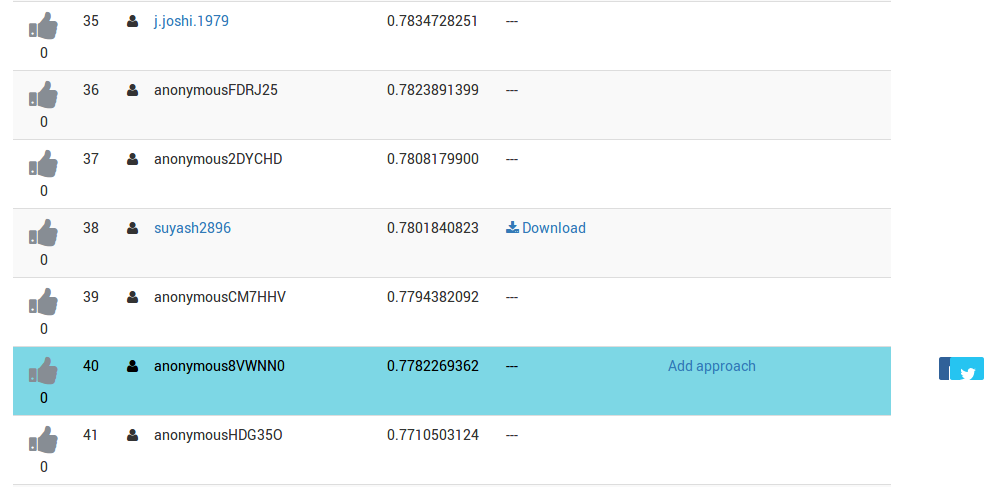

In [16]:
# Relaxed/Partial F1 score on private leaderboard was 77.8%
# Partial F1 score: F1 score with considering partial disease name detection

from IPython.display import Image
Image(filename='/home/abhijeet/Pictures/F1_score.png')